In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget

import importlib
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import ExperimentClass
import tools


In [2]:
importlib.reload(ExperimentClass)
importlib.reload(tools)
manip = ExperimentClass.Experiment("20230519_Ek", "JTS", local = "IBPC")

In [3]:
calib = ExperimentClass.Experiment("20230519_ECS_calib", "JTS")

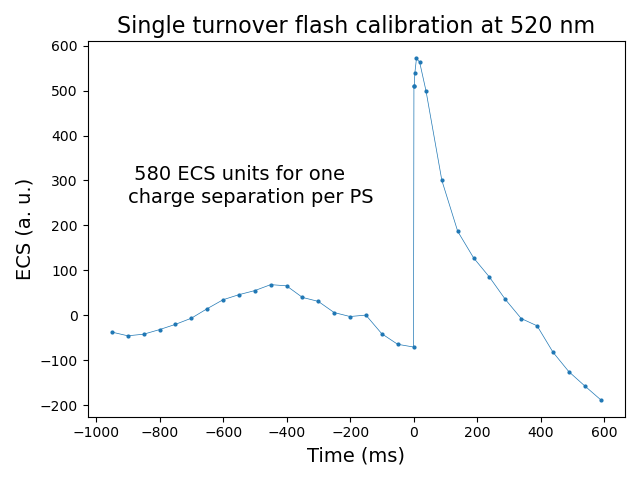

In [4]:
fig, ax1 = plt.subplots(1,1)
ax1.plot(calib.clean_times[0], calib.clean_data[0], 'o-', linewidth = 0.5, markersize = 2)
ax1.set_title("Single turnover flash calibration at 520 nm", fontsize = 16)
ax1.set_xlabel("Time (ms)", fontsize = 14)
ax1.set_ylabel("ECS (a. u.)", fontsize = 14)
delta = calib.clean_data[0][20] - calib.clean_data[0][19]

ax1.text( -900, 300, f"{delta : .0f} ECS units for one", fontsize = 14)
ax1.text( -900, 250, f"charge separation per PS", fontsize = 14)

fig.tight_layout()

In [5]:
#Here I visually select an interval in the data that is free of artifacts and close to the pulse of dark,
#then I subtract the average of this interval from the data

for i in manip.records:
    manip.Data[i] = manip.Data[i] - np.average(manip.Data[i][160:180])

In [6]:
#Here I perform the average of the recordings and crop the data to the interval of interest

records = ["11-14", "21-25", "31-35","41-45", "51-55", "61-65", "71-75", "81-85", "91-95", "101-105","112-115", 
           "121-125", "131-135", "141-145", "151-155", "161-165", "171-175", "181-185", "191-195", "201-205"]

PWM_rel = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.85]

mean_curves = []
std_curves = []

for i in records:
    mean, std = manip.average_recordings(tools.create_record_list(i))
    mean_curves.append(mean[201:300])
    std_curves.append(std[201:300])

time = manip.Time[201:300] - 203
    



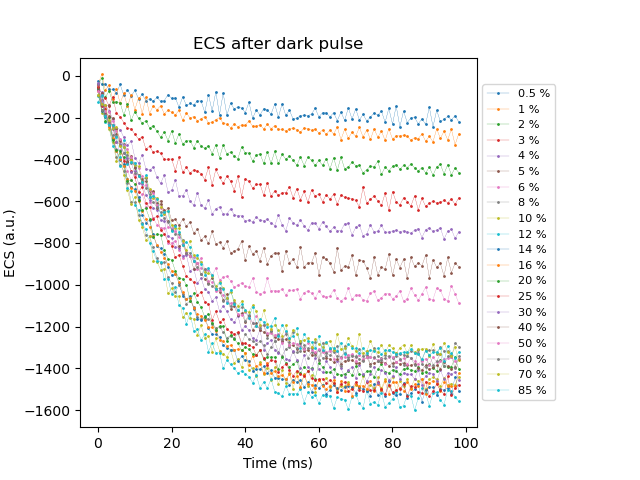

In [7]:
fig, ax = plt.subplots()
for i, k in enumerate(PWM_rel):
    ax.plot(time, mean_curves[i], 'o-', label = f"{100*k:n} %", markersize = 1, linewidth = 0.2)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 8.1)
ax.set_xlabel("Time (ms)")
ax.set_ylabel("ECS (a.u.)")
ax.set_title("ECS after dark pulse")
plt.show()

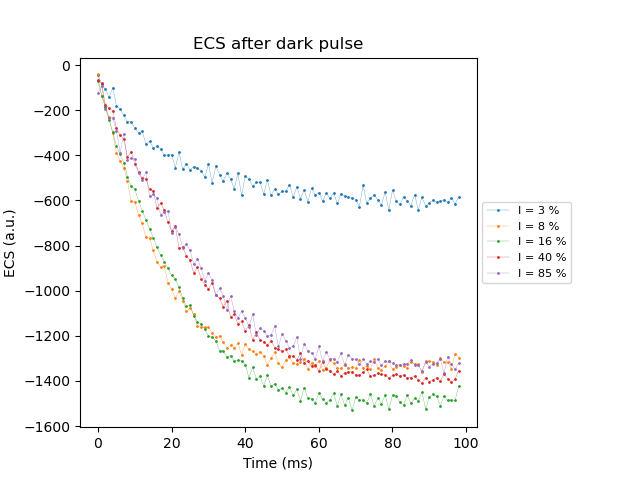

In [8]:
fig, ax = plt.subplots()
for i, k in enumerate([3,7,11,15,19]):
    ax.plot(time, mean_curves[k], 'o-', label = f"I = {100*PWM_rel[k]:n} %", markersize = 1, linewidth = 0.2)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 8.1)
ax.set_xlabel("Time (ms)")
ax.set_ylabel("ECS (a.u.)")
ax.set_title("ECS after dark pulse")
plt.show()

# $E_{k}$ determination using PWM

c:\Users\Orlando\anaconda3\envs\PhD_environment\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


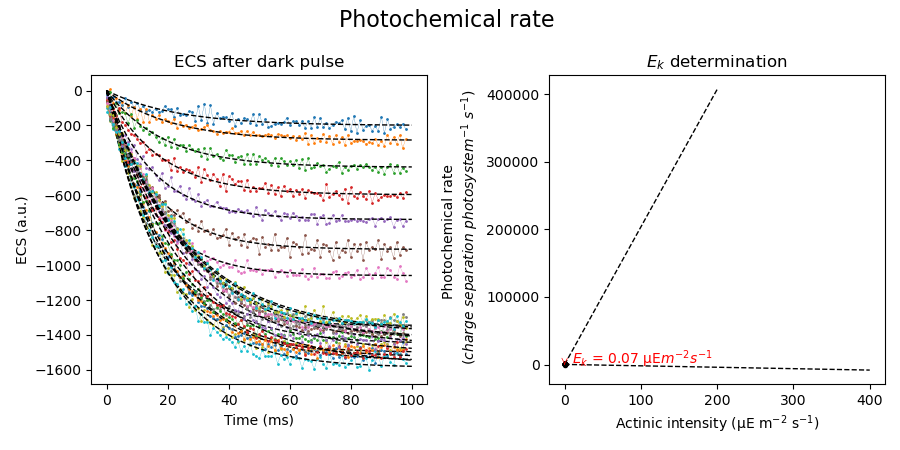

In [12]:
import math_functions as mf
importlib.reload(mf)
importlib.reload(tools)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (9,4.5))
figure_name = "Photochemical rate "
fig.suptitle(figure_name, fontsize = 16)

Intensity = 1326 * np.asarray(PWM_rel) + 11.9
Intensity = PWM_rel.copy()

start = 0
stop = 100
num = 50

xfit = []
yfit = []
param = []
vitesse = []

xdata = time.copy()


for i, k in enumerate(PWM_rel):
    ax1.plot(time, mean_curves[i], 'o-', label = f"I = {100*k:n} %", markersize = 1, linewidth = 0.2)
    ydata = mean_curves[i]
    popt, x, y =  tools.exp_decay_fit(xdata, ydata, start, stop, num, p0 = [200,20])
    xfit.append(x)
    yfit.append(y)
    param.append(popt)
    ax1.plot(xfit[i],yfit[i], '--', color ='k', linewidth = 1)
    vitesse.append(-1000*param[i][0]/(delta*param[i][1]))
    
ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("ECS (a.u.)")
ax1.set_title("ECS after dark pulse")
    
#Intensity.insert(0,0)
Intensity = np.insert(Intensity, 0, 0)
vitesse.insert(0,0)

ax2.plot(Intensity, vitesse,'o', color ='k', markersize = 3)

Ek_fit = "lin" # "lin", "exp", overshoot" or "test"

if Ek_fit == "exp":   
    popt, xfit, yfit = tools.Ek_fit(Intensity[0:10], vitesse[0:10], 0, 200, 50, p0 = [88, 0.07])
    ax2.plot(xfit, yfit, '--', color ='k', linewidth = 1)
    Ek = popt[1]
    ax2.annotate("", xy=(Ek, ax2.get_ylim()[0]), xytext=(Ek, ax2.get_ylim()[1]), arrowprops=dict(arrowstyle="->", color="red", linewidth = 0.5))
    ax2.text(0.1, 30, f"$E_k$ = {Ek:.2f}", fontsize = 10, color = "red")

if Ek_fit == "lin":
    popt1, x1fit, y1fit = tools.lin_fit(Intensity[0:8], vitesse[0:8], 0, 200,30)
    popt2, x2fit, y2fit = tools.lin_fit(Intensity[8:10], vitesse[8:10], 0, 400,30)
    ax2.plot(x1fit, y1fit, '--', color ='k', linewidth = 1)
    ax2.plot(x2fit, y2fit, '--', color ='k', linewidth = 1)
    Ek = (popt2[1] - popt1[1])/(popt1[0] - popt2[0])
    ax2.annotate("", xy=(Ek, 0), xytext=(Ek, 200), arrowprops=dict(arrowstyle="->", color="red", linewidth = 0.5))
    ax2.text(Ek + 10, 30, f"$E_k$ = {Ek:.2f}" + " µE$m^{-2} s^{-1}$", fontsize = 10, color = "red")
    
    
if Ek_fit == "overshoot":   
    popt, xfit, yfit = tools.sat_overshoot_fit(Intensity, vitesse, 0, 0.8, 50, p0 = [55, 0.02, 40, 0.1])
    ax2.plot(xfit, yfit, '--', color ='k', linewidth = 1)
    Ek = popt[1]
    ax2.annotate("", xy=(Ek, ax2.get_ylim()[0]), xytext=(Ek, ax2.get_ylim()[1]), arrowprops=dict(arrowstyle="->", color="red", linewidth = 0.5))
    ax2.text(Ek + 10, 30, f"$E_k$ = {Ek:.0f}", fontsize = 10, color = "red")
    
   


ax2.set_title("$E_{k}$ determination")
ax2.set_xlabel("Actinic intensity (µE m$^{-2}$ s$^{-1}$)")
ax2.set_ylabel("Photochemical rate \n ($charge$ $separation$ $photosystem^{-1}$ $s^{-1}$)")
# ax2.set_xlim([0,0.13])
# ax2.set_ylim([0,100])

fig.tight_layout()

plt.show()

fig_folder = manip.path + "/Figures"
if not os.path.isdir(fig_folder):
    os.mkdir(fig_folder)

fig.savefig(fig_folder + "/" + figure_name + Ek_fit + ".png")

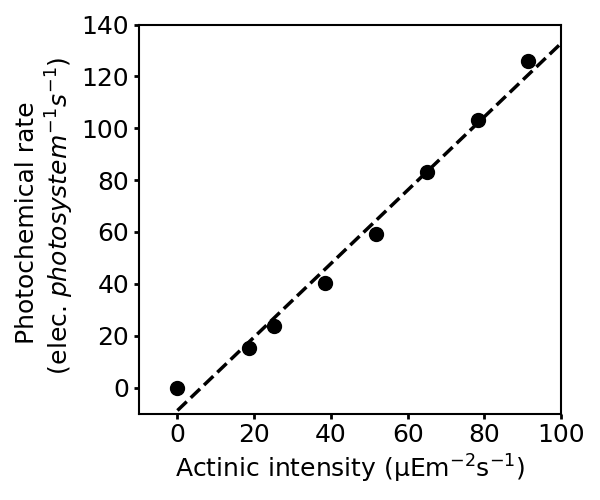

In [10]:
line = 2.5
marker = 10
labelsize = 18
legendfontsize = 14

fig, ax = plt.subplots(figsize=(6,5), facecolor='none')
fig_title = "Ek"


ax.plot(Intensity, vitesse, "o", markersize=marker, color = "black")
ax.plot(x1fit, y1fit, '--', color ='k',linewidth=line)
ax.set_xlabel("Actinic intensity (µEm$^{-2}$s$^{-1}$)", fontsize = labelsize)
ax.set_ylabel("Photochemical rate \n (elec. $photosystem^{-1}s^{-1}$)", fontsize = labelsize)
ax.set_ylim(-10, 140)
ax.set_xlim(-10, 100)

ax = plt.gca()
ax.tick_params(axis='both', which='both', width=2)

for label in ax.xaxis.get_ticklabels():
    label.set_fontsize(labelsize)
    
for label in ax.yaxis.get_ticklabels():
    label.set_fontsize(labelsize)

for spine in ax.spines.values():
    spine.set_linewidth(1.5)

fig.tight_layout()
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

fig.savefig(fig_folder + "ekposter.png", dpi=300)